## CNN autoencoder
### convLSTM autoencoder?

## Prepare data

In [1]:
from matplotlib import pyplot
import keras
import tensorflow as tf
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import GRU
from keras.layers import Conv3D
from keras.layers import MaxPool3D
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import numpy as np
from numpy import array

In [2]:
from data_processing import process
filename = 'gear_dataset.csv'
rows = 1000
data, IDs = process(filename,rows)
n_rows = data.shape[0] 
n_features = data.shape[1]
print(data.shape)


(989, 64)


## fixa så att det är uppdelat på kanske $40\cdot64\cdot2$

In [3]:
# do cube with stream*64*ID

def convert_from_hex(hex,output_type): # converts the data in hex from hexadecimal to decimal or binary form
     out = np.zeros((hex.size))
     if output_type == 'dec':
        for x in range(hex.size):
            h_value = hex[x]
            out[x] = int(h_value,16)
     else:
        for x in range(hex.size):
            h_value = hex[x]
            binary[x] = bin(int(h_value, 16))[2:]

     return out


#data = convert_from_hex(Data,'dec')
IDs = IDs.reset_index(drop=True)

id = convert_from_hex(IDs,'dec') 

ID_matrix =  array([[id],]*data.shape[1]).transpose()
ID_matrix = np.squeeze(ID_matrix)
dataCube = np.dstack([data,ID_matrix])

In [4]:
n_timesteps = 40
n_samples = int(np.floor(dataCube.shape[0]/n_timesteps))
print(n_samples)

last_timestep = n_samples*n_timesteps
x = dataCube[0:last_timestep,:,:]
print(x.shape)
x = x.reshape(n_samples,n_timesteps,64,2,1)
print(x.shape)

train_size = int(np.floor(0.7*n_samples))
x_train = x[0:train_size,:,:,:,:]
x_test = x[train_size:,:,:,:,:]

print(x_test.shape, x_train.shape)

24
(960, 64, 2)
(24, 40, 64, 2, 1)
(8, 40, 64, 2, 1) (16, 40, 64, 2, 1)


## Build network

In [12]:
# channels?? 2d or 3d? think 3d because there are correlations between the two cannels
# relu much better than sigmoid
n_features = 64
n_3rd = 2
n_channels = 2

input = Input(shape=(n_timesteps,n_features,n_channels, 1))

l1 = Conv3D(filters = 16, kernel_size = (3, 3, 3), activation='relu', padding='same')(input)
l2 = Conv3D(filters = 16, kernel_size = (3, 3, 3), activation='relu', padding='same')(l1)
l3 = MaxPool3D((2,2,2),padding='valid')(l2)
l4 = Conv3D(filters = 16, kernel_size = (3, 3, 3), activation='relu', padding='same')(l3)
l5 = Conv3D(filters = 1, kernel_size = (3, 3, 3), activation='relu', padding='same')(l4)


CNN = Model(inputs=input, outputs=l5,name="CNN")
CNN.compile(optimizer='adam', loss='mse')
CNN.summary()


Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 40, 64, 2, 1)]    0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 40, 64, 2, 16)     448       
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 40, 64, 2, 16)     6928      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 20, 32, 1, 16)     0         
_________________________________________________________________
conv3d_18 (Conv3D)           (None, 20, 32, 1, 16)     6928      
_________________________________________________________________
conv3d_19 (Conv3D)           (None, 20, 32, 1, 1)      433       
Total params: 14,737
Trainable params: 14,737
Non-trainable params: 0
___________________________________________________________

Epoch 1/300
1/1 - 0s - loss: 308127.0938 - val_loss: 305454.0000
Epoch 2/300
1/1 - 0s - loss: 296657.8750 - val_loss: 288742.9375
Epoch 3/300
1/1 - 0s - loss: 280644.3750 - val_loss: 269934.5625
Epoch 4/300
1/1 - 0s - loss: 262451.8125 - val_loss: 247000.5938
Epoch 5/300
1/1 - 0s - loss: 240259.2031 - val_loss: 218677.8438
Epoch 6/300
1/1 - 0s - loss: 212593.8750 - val_loss: 184471.7812
Epoch 7/300
1/1 - 0s - loss: 179289.6094 - val_loss: 144558.6250
Epoch 8/300
1/1 - 0s - loss: 140483.8281 - val_loss: 100779.3359
Epoch 9/300
1/1 - 0s - loss: 97883.3359 - val_loss: 59036.3516
Epoch 10/300
1/1 - 0s - loss: 57284.6797 - val_loss: 35248.6250
Epoch 11/300
1/1 - 0s - loss: 34240.3750 - val_loss: 53116.3750
Epoch 12/300
1/1 - 0s - loss: 52090.3711 - val_loss: 80720.5391
Epoch 13/300
1/1 - 0s - loss: 79373.4844 - val_loss: 77908.5469
Epoch 14/300
1/1 - 0s - loss: 76646.0469 - val_loss: 58229.0195
Epoch 15/300
1/1 - 0s - loss: 57205.2734 - val_loss: 40545.8672
Epoch 16/300
1/1 - 0s - loss: 397

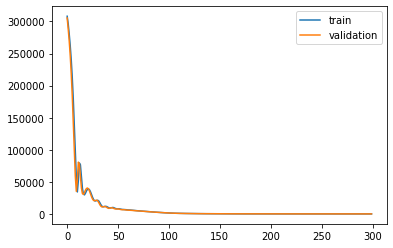

training time = 264.30518770217896 seconds


In [6]:

import time

model = CNN
es= EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=10)

s=time.time()

history = model.fit(x_train,x_train, validation_data=(x_test, x_test), epochs=300, verbose=2, shuffle=False, callbacks = [es])

e=time.time()

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='validation')

pyplot.legend()
pyplot.show()
print(f'training time = {e-s} seconds')

In [ ]:
# from https://keras.io/examples/vision/3D_image_classification/

def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()